In [1]:
import pandas as pd
import numpy as np
import math
import json
import os

from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(rc={'figure.figsize':(24, 15)}, font_scale=2)

from tqdm import tqdm
from glob import glob

# Epanechnikov Kernel (Streaming)

In [4]:
regions_df = pd.read_pickle('../streaming_data/high_residual/consistent/regions_df.pickle')
df = pd.read_pickle('../streaming_data/high_residual/consistent/df_full.pickle')
df = df.sort_values(by='unix_time')

# Add unix time to the regions_df
regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values
regions_df

,region_id,start,end,length,unix_start,unix_end
0,0,516,539,24,1.592827e+09,1.592910e+09
1,1,965,988,24,1.594444e+09,1.594526e+09
2,2,1100,1123,24,1.594930e+09,1.595012e+09
3,3,1719,1742,24,1.597158e+09,1.597241e+09
4,4,2089,2112,24,1.598490e+09,1.598573e+09
5,5,3109,3132,24,1.602162e+09,1.602245e+09
6,6,3682,3705,24,1.604225e+09,1.604308e+09
7,7,3868,3891,24,1.604894e+09,1.604977e+09
8,8,4058,4081,24,1.605578e+09,1.605661e+09
9,9,4662,4685,24,1.607753e+09,1.607836e+09


In [6]:
# For each consecutive execution check the found clusters and if they make it into the top k
k = 3

# Get a list of all the diretories to loop through
dir_paths = glob("../streaming_data/high_residual/consistent/outputs/*/")

# Dataframe that corresponds to all the alerts that were sent out while streaming
alerts_df = pd.DataFrame(columns=['alert_time', 'cluster_start', 'alert_idx', 'cluster_start_idx'])

for dir_path in tqdm(sorted(dir_paths)):
    clusters = pd.read_pickle(dir_path + 'clusters_df.pickle')
    clusters['rank'] = clusters['area'].rank(ascending=False)

    last_cluster_id = clusters['cluster_id'].max() 
    last_cluster_rank = clusters[clusters['cluster_id'] == last_cluster_id]['rank'].values[0]

    # Adjust k
    df = pd.read_pickle(dir_path + 'df.pickle')
    new_k = len(regions_df[regions_df['unix_start'] <= df['unix_time'].max()].index)
    if k != new_k:
        k=new_k

    print(df.columns)
    break
    
    # Check if last cluster makes it into the top-k
    if last_cluster_rank <= k:
        last_cluster_start = clusters[clusters['cluster_id'] == last_cluster_id]['start'].values[0]
        last_cluster_start_idx = df.iloc[(df['unix_time']-last_cluster_start).abs().argsort()[:1]].index.values[0]

        alert_time = df['unix_time'].max()
        if alerts_df.empty:
            alerts_df.loc[len(alerts_df.index)] = [alert_time, last_cluster_start, len(df.index), last_cluster_start_idx]
        else:
            # Check if there is already an alert after the current cluster_start
            latest_recorded_alert = alerts_df['alert_time'].max()
            if last_cluster_start > latest_recorded_alert:
                alerts_df.loc[len(alerts_df.index)] = [alert_time, last_cluster_start, len(df.index), last_cluster_start_idx]

alerts_df

  0%|          | 0/630 [00:00<?, ?it/s]

Index(['time', 'timestamp', 'measure', 'signal', 'noise', 'is_outlier',
       'outlier_type', 'region_id', 'yhat', 'yhat_lower', 'yhat_upper',
       'residual', 'abs_residual', 'norm_residual', 'percent_error',
       'is_outlier_raw_data_fit', 'is_outlier_num_outliers',
       'is_outlier_residual', 'num_raw_data_fit_outliers_norm_residual',
       'residual_sum_norm_residual', 'raw_voting_score', 'weighted_score',
       'unix_time', 'cluster_id', 'start', 'end', 'point_start', 'point_end',
       'time_length', 'num_points', 'area', 'area_pts'],
      dtype='object')


,alert_time,cluster_start,alert_idx,cluster_start_idx


In [196]:
def get_alerts_coverage(alerts_df, regions_df):
    '''
    Given an alerts_df and regions_df dataframes update the alerts_df dataframe with information about its coverage based on the true regions specified in `regions_df`
    '''
    # Process alerts_df to check for accuracy and what region it corresponds to if it is correct
    alerts_df['region_id_covered'] = np.nan
    alerts_df['alert_in_region'] = False
    for index, alert in alerts_df.iterrows():
        for _, region in regions_df.iterrows():
            # Check if the alert['alert_time'] happens during the interval of a true region
            if (alert['alert_time'] >= region['unix_start'] and alert['alert_time'] <= region['unix_end']):
                alerts_df.loc[index, 'alert_in_region'] = True

            # Check if there is a true region that has an overlap with the interval [row['cluster_start'], row['alert_time']]
            if (region['unix_start'] <= alert['cluster_start'] <= region['unix_end']) or (alert['cluster_start'] <= region['unix_start'] <= alert['alert_time']):
                alerts_df.loc[index, 'region_id_covered'] = region['region_id']

    return alerts_df

alerts_df = get_alerts_coverage(alerts_df=alerts_df, regions_df=regions_df)
print("A total of", alerts_df['region_id_covered'].nunique(), 'alerts cover a true regions and', alerts_df['alert_in_region'].value_counts()[True], 'of them were alerted during a true region')
alerts_df

A total of 8 alerts cover a true regions and 4 of them were alerted during a true region


,alert_time,cluster_start,alert_idx,cluster_start_idx,region_id_covered,alert_in_region
0,1.595524e+09,1.594796e+09,1266.0,1063.0,2.0,False
1,1.596085e+09,1.595657e+09,1422.0,1302.0,NaN,False
2,1.596928e+09,1.596589e+09,1656.0,1561.0,NaN,False
3,1.597273e+09,1.597007e+09,1752.0,1677.0,3.0,False
4,1.598526e+09,1.597878e+09,2100.0,1919.0,4.0,True
5,1.599628e+09,1.599117e+09,2406.0,2263.0,NaN,False
6,1.602241e+09,1.601986e+09,3132.0,3060.0,5.0,True
7,1.604315e+09,1.603954e+09,3708.0,3607.0,6.0,False
8,1.604941e+09,1.604599e+09,3882.0,3786.0,7.0,True
9,1.605654e+09,1.605398e+09,4080.0,4008.0,8.0,True


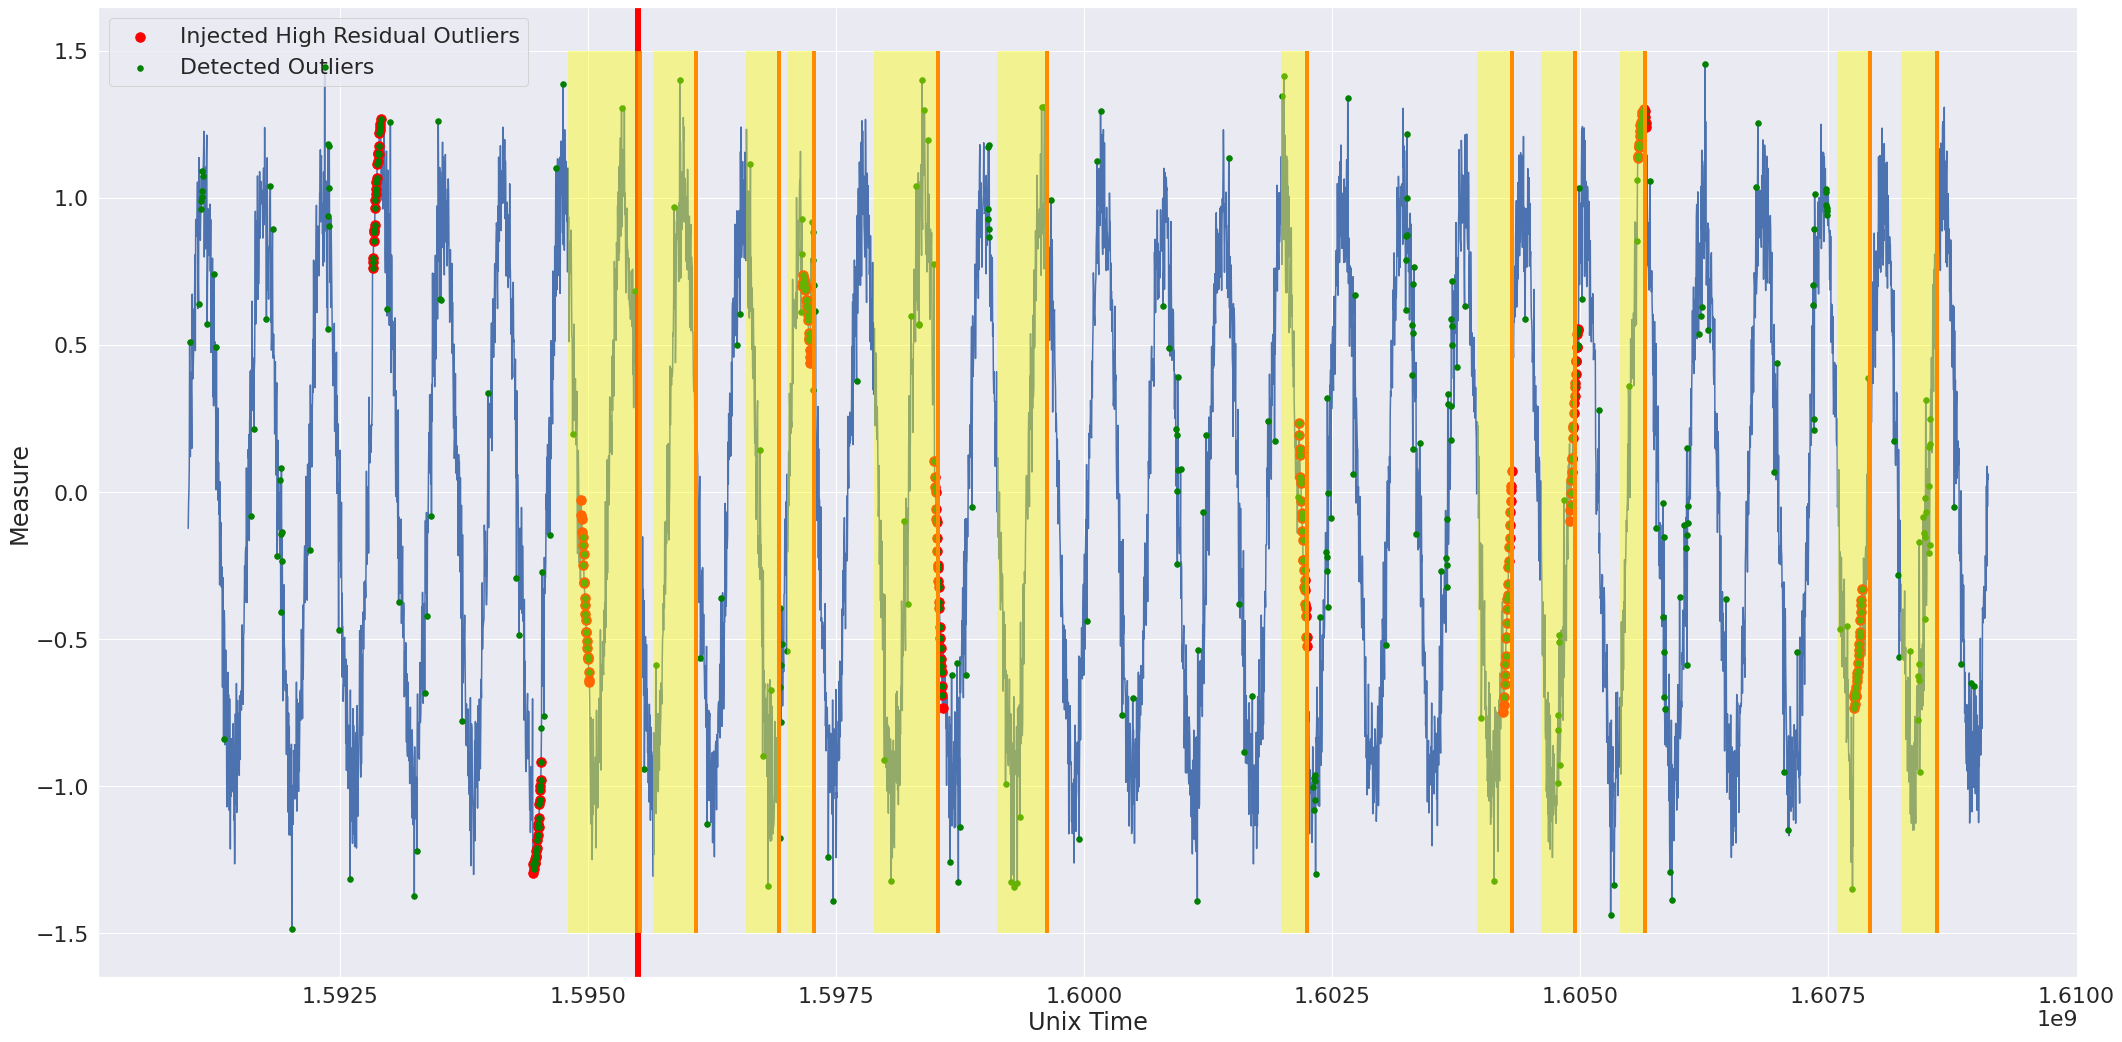

In [198]:
df = pd.read_pickle('../streaming_data/high_residual/consistent/df_full.pickle')
df = df.sort_values(by='unix_time')


fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (30,15)


plt.plot(df['unix_time'], df['measure'])
plt.scatter(df[df['outlier_type']=='high_residual']['unix_time'].values, df[df['outlier_type']=='high_residual']['measure'].values, s=90, c='red', zorder=10, label='Injected High Residual Outliers')
plt.scatter(df[df['raw_voting_score']>0]['unix_time'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')


plt.vlines(alerts_df['alert_time'], ymin=-1.5, ymax=1.5, colors='darkorange', linewidth=4, zorder=100)

# Plot the alert regions
for _, alert in alerts_df.iterrows():
    ax.add_patch(patches.Rectangle((alert['cluster_start'], -1.5), width=alert['alert_time']-alert['cluster_start'], height=3, linewidth=0, color='yellow', zorder=10, alpha=0.40))

plt.axvline(df.loc[1260]['unix_time'], c='red', linewidth=6)

plt.ylabel('Measure');plt.xlabel('Unix Time');plt.legend();plt.tight_layout()
plt.savefig('../figures/streaming/streaming_top_k_alerts.svg')

# Epanechnikov Kernel (Offline)

In [179]:
import sys
sys.path.append('../')
import utils

In [180]:
regions_df = pd.read_pickle('../streaming_data/high_residual/consistent/regions_df.pickle')
df = pd.read_pickle('../streaming_data/high_residual/consistent/df_full.pickle')
df = df.sort_values(by='unix_time')

# Add unix time to the regions_df
regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values
regions_df

,region_id,start,end,length,unix_start,unix_end
0,0,516,539,24,1.592827e+09,1.592910e+09
1,1,965,988,24,1.594444e+09,1.594526e+09
2,2,1100,1123,24,1.594930e+09,1.595012e+09
3,3,1719,1742,24,1.597158e+09,1.597241e+09
4,4,2089,2112,24,1.598490e+09,1.598573e+09
5,5,3109,3132,24,1.602162e+09,1.602245e+09
6,6,3682,3705,24,1.604225e+09,1.604308e+09
7,7,3868,3891,24,1.604894e+09,1.604977e+09
8,8,4058,4081,24,1.605578e+09,1.605661e+09
9,9,4662,4685,24,1.607753e+09,1.607836e+09


In [181]:
last_computation_dir = "../streaming_data/high_residual/consistent/outputs/size_5034/"

clusters_df = pd.read_pickle(last_computation_dir + 'clusters_df.pickle').sort_values(by='area', ascending=False)
density_df = pd.read_pickle(last_computation_dir + 'density_df.pickle').sort_values(by='unix_time')

# Add the `density_at_start` column to the clusters_df
densities = []
for index, row in clusters_df.iterrows():
    density = density_df[density_df['unix_time']==row['start']]['density'].values[0]
    densities.append(density)
clusters_df['density_at_start'] = densities

clusters_df

,cluster_id,start,end,point_start,point_end,time_length,num_points,area,area_pts,density_at_start
23,33,1.596975e+09,1.597446e+09,1.597000e+09,1.597421e+09,471537.540560,34,0.094035,0.091464,6.661638e-08
28,42,1.598158e+09,1.598861e+09,1.598252e+09,1.598803e+09,703106.867095,37,0.068327,0.064501,1.253846e-08
49,69,1.604728e+09,1.605158e+09,1.604783e+09,1.605017e+09,429543.103106,27,0.063629,0.046764,2.220513e-08
7,8,1.592654e+09,1.593149e+09,1.592827e+09,1.593090e+09,494334.520893,32,0.061558,0.044356,7.197632e-09
52,73,1.605398e+09,1.605824e+09,1.605485e+09,1.605766e+09,425943.579895,26,0.053779,0.044961,1.785155e-08
...,...,...,...,...,...,...,...,...,...,...
24,35,1.597464e+09,1.597496e+09,1.597468e+09,1.597468e+09,31195.867823,1,0.000798,0.000000,2.602352e-08
32,48,1.599836e+09,1.599955e+09,1.599948e+09,1.599948e+09,118784.265943,1,0.000776,0.000000,4.432176e-09
42,62,1.602631e+09,1.602658e+09,1.602655e+09,1.602655e+09,27596.344613,1,0.000554,0.000000,2.084009e-08
0,0,1.590970e+09,1.590988e+09,1.590984e+09,1.590984e+09,17997.616052,1,0.000137,0.000000,7.548401e-09


## Range-Based Evaluation

In [182]:
def range_based_recall(real_ranges, predicted_ranges, alpha=0.5, delta_mode='flat'):
    '''
    Returns the range based recall given the predicted and groundtruth range-based anomalies
    '''
    recall_sum = 0
    for real_range in real_ranges:
        recall_sum += recall_per_real_range(real_range=real_range, predicted_ranges=predicted_ranges, alpha=alpha, delta_mode=delta_mode)
    
    return recall_sum / len(real_ranges)

def range_based_precision(real_ranges, predicted_ranges, delta_mode='flat'):
    precision_sum = 0
    for predicted_range in predicted_ranges:
        precision_sum += precision_per_predicted_range(real_ranges, predicted_range, delta_mode)
    return precision_sum / len(predicted_ranges)

def recall_per_real_range(real_range, predicted_ranges, alpha, delta_mode):
    return alpha*existence_reward(real_range, predicted_ranges) + (1-alpha)*overlap_reward(real_range, predicted_ranges, delta_mode)

def precision_per_predicted_range(real_ranges, predicted_range, delta_mode):
    total_score = 0
    card_factor = cardinality_factor(single_range=predicted_range, multiple_ranges=real_ranges)
    for real_range in real_ranges:
        overlap_range = get_overlap_range(real_range, predicted_range)
        total_score += card_factor * omega(anomaly_range=predicted_range, overlap=overlap_range, delta_mode=delta_mode)
    return total_score

def existence_reward(real_range, predicted_ranges):
    for predicted_range in predicted_ranges:
        if regions_overlap(real_range, predicted_range):
            return 1
    return 0


def overlap_reward(real_range, predicted_ranges, delta_mode):
    total_reward = 0
    card_factor = cardinality_factor(single_range=real_range, multiple_ranges=predicted_ranges)
    for pred_range in predicted_ranges:
        overlap_range = get_overlap_range(real_range, pred_range)
        total_reward += card_factor * omega(anomaly_range=real_range, overlap=overlap_range, delta_mode=delta_mode)
    return total_reward

def regions_overlap(reg1, reg2):
    '''
    Return True if there is an overlap between `reg1` and `reg2` otherwise return False
    '''
    if ( (reg1[0] <= reg2[1]) and (reg2[0] <= reg1[1]) ):
        return True
    else:
        False

def get_overlap_range(reg1, reg2):
    '''
    Return as a 2 element list the overlapping region between `reg1` and `reg2`.
    If there is no overlap then just return [0,0] as the overlapping region
    '''
    if (not regions_overlap(reg1, reg2)):
        return [0, 0]
    else:
        overlap_start = max(reg1[0], reg2[0])
        overlap_end = max(reg1[1], reg2[1])
        return [overlap_start, overlap_end]

def cardinality_factor(single_range, multiple_ranges):
    '''
    Returns 1 if `single_range` overlaps at most once with a range in `multiple_ranges`

    Otherwise return gamma(single_range, multiple_ranges) which is usually equivalent to 1/x 
    where x is the number of overlaps single_range has with multiple_ranges
    '''
    num_overlaps = 0
    for cur_range in multiple_ranges:
        if (regions_overlap(single_range, cur_range)):
            num_overlaps += 1
    
    if num_overlaps <= 1:
        return 1
    else:
        # The gamma function is currently set as 1/x where x is the number of overlaps
        return 1/num_overlaps

def omega(anomaly_range, overlap, delta_mode):
    if overlap == [0,0]:
        # If there is no overlap we return 0
        return 0
    
    my_value = 0
    max_value = 0

    # TODO: Split the anomaly_range to appropriate units (currently the anomaly range is defined in unix time and we split it to hour points)
    point_size = 3600
    anomaly_length = math.floor(((anomaly_range[1] - anomaly_range[0]) / point_size)) + 1
    anomaly_range_pts = []
    for i in range(anomaly_length):
        anomaly_range_pts.append(anomaly_range[0] + i*point_size)

    for i in range(anomaly_length):
        bias = delta(i, anomaly_length, mode=delta_mode)
        max_value += bias
        if (anomaly_range_pts[i] >= overlap[0] and anomaly_range_pts[i] <= overlap[1]):
            my_value += bias
    
    if max_value == 0:
        return 0
    return my_value / max_value

def delta(i, anomaly_length, mode):
    if mode == 'flat':
        return 1
    elif mode == 'front_end_bias':
        return anomaly_length - i + 1

In [183]:
# Extract the real anomaly ranges and the predicted anomaly ranges
real_ranges = []
predicted_ranges = []
for i, row in regions_df.iterrows():
    real_ranges.append([row['unix_start'], row['unix_end']])
for i, row in clusters_df.iterrows():
    predicted_ranges.append([row['start'], row['end']])
predicted_ranges = predicted_ranges[:len(real_ranges)]

In [199]:
recall = range_based_recall(real_ranges=real_ranges, predicted_ranges=predicted_ranges, alpha=0.5, delta_mode='front_end_bias')
precision = range_based_precision(real_ranges=real_ranges, predicted_ranges=predicted_ranges, delta_mode='front_end_bias')
print("Recall:", recall, "Precision:", precision)

Recall: 0.7 Precision: 0.2426986056617892


## Figures

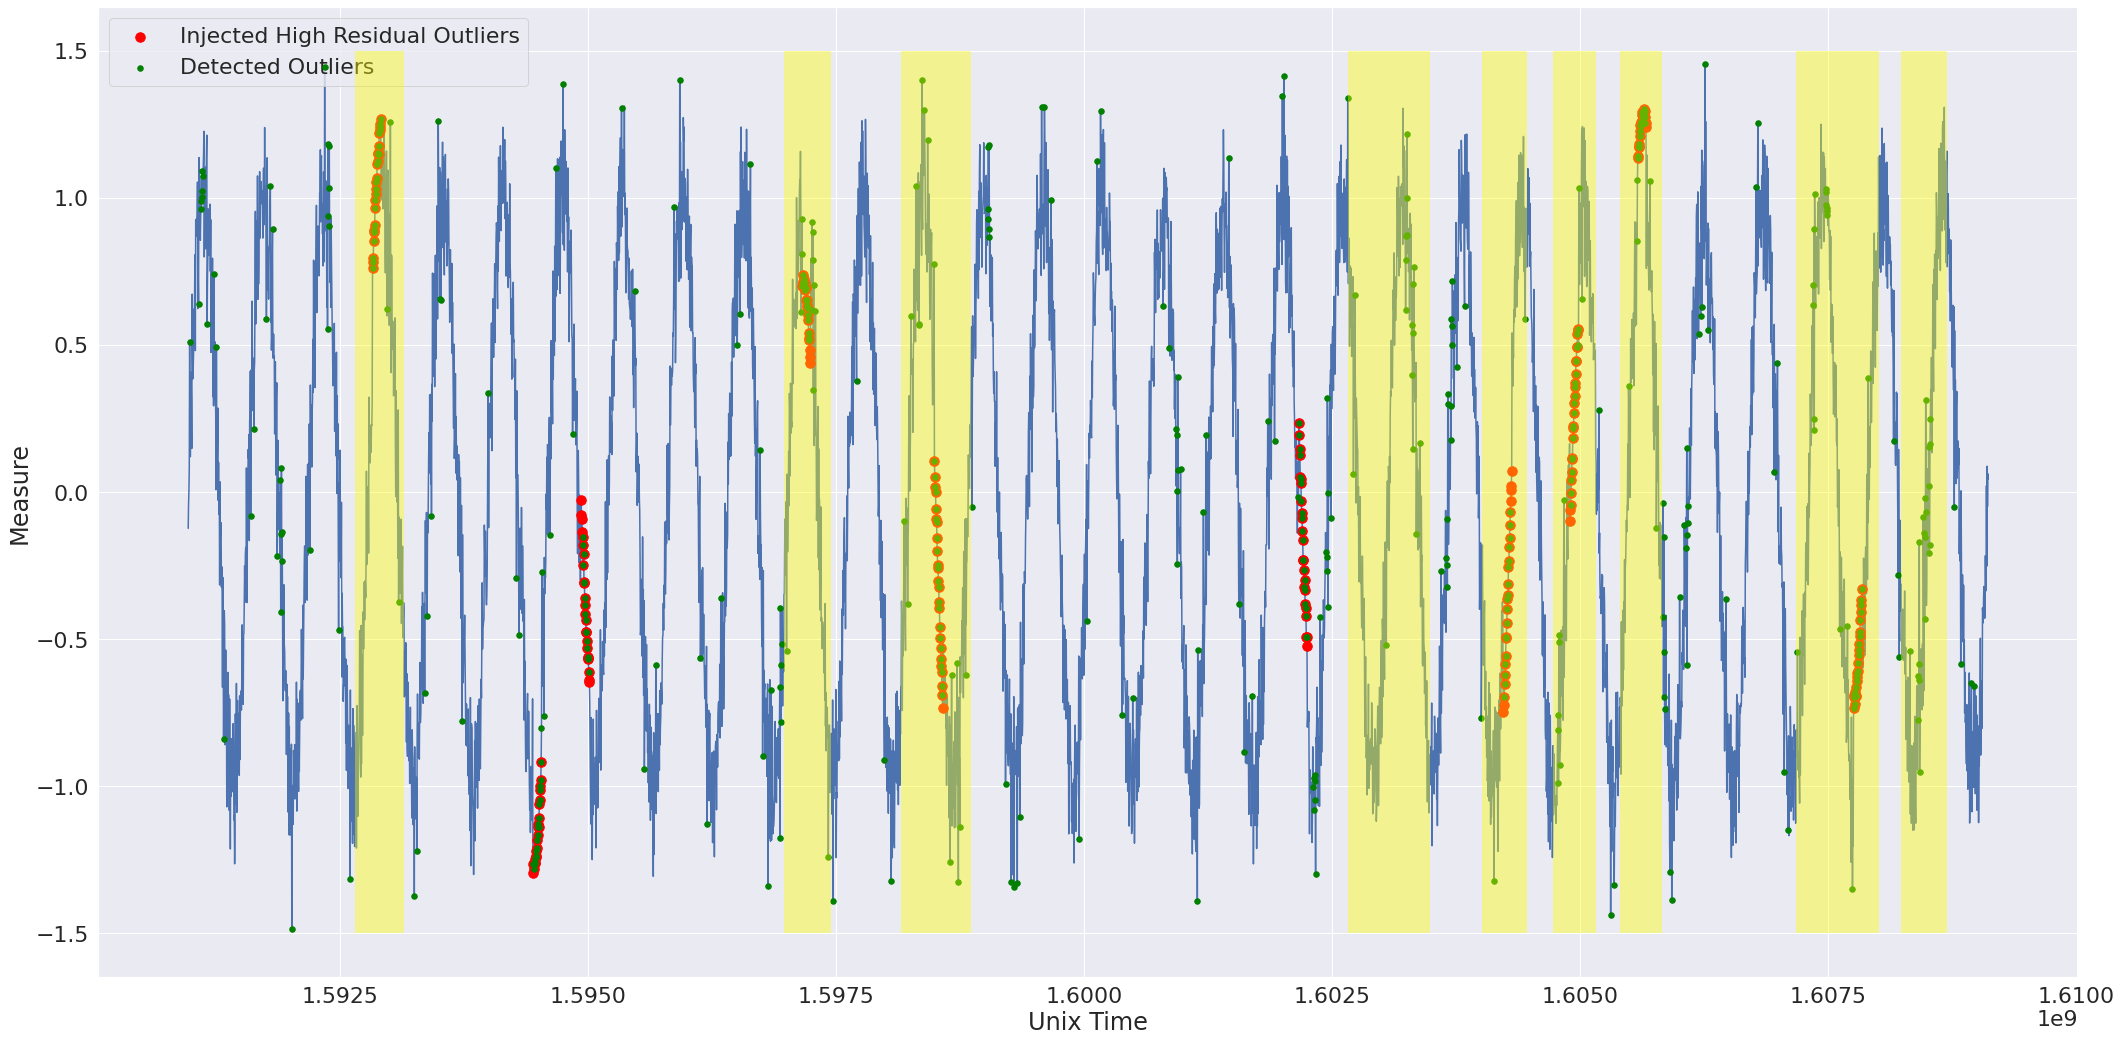

In [185]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (30,15)

plt.plot(df['unix_time'], df['measure'])
plt.scatter(df[df['outlier_type']=='high_residual']['unix_time'].values, df[df['outlier_type']=='high_residual']['measure'].values, s=90, c='red', zorder=10, label='Injected High Residual Outliers')
plt.scatter(df[df['raw_voting_score']>0]['unix_time'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')

# Plot the top-10 outlier clusters
for _, cluster in clusters_df.head(10).iterrows():
    ax.add_patch(patches.Rectangle((cluster['start'], -1.5), width=cluster['end']-cluster['start'], height=3, linewidth=0, color='yellow', zorder=10, alpha=0.40))

plt.ylabel('Measure');plt.xlabel('Unix Time');plt.legend();plt.tight_layout()
plt.savefig('../figures/streaming/raw_alerts.svg')

In [186]:
def get_raw_and_density_plot(df, density_df, clusters_df, clusters_to_highlight, save_path=None):
    # Plot the Figure
    fig, axs = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0)

    # Construct the top plot (raw time series) 
    axs[0].plot(df['unix_time'], df['measure'])
    axs[0].scatter(df[df['outlier_type']=='high_residual']['unix_time'].values, df[df['outlier_type']=='high_residual']['measure'].values, s=90, c='red', zorder=10, label='Injected High Residual Outliers')
    axs[0].scatter(df[df['raw_voting_score']>0]['unix_time'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')

    # Plot the top-10 outlier clusters
    for _, cluster in clusters_to_highlight.iterrows():
        axs[0].add_patch(patches.Rectangle((cluster['start'], -1.5), width=cluster['end']-cluster['start'], height=3, linewidth=0, color='yellow', zorder=10, alpha=0.40))
    axs[0].set_ylabel('Measure');axs[0].legend()

    # Plot the bottom plot (density function)
    axs[1].plot(density_df['unix_time'], density_df['density'])
    axs[1].scatter(clusters_df['start'], clusters_df['density_at_start'], c='red', label='local minima')
    axs[1].set_ylabel('Density');axs[1].set_xlabel('Time');axs[1].legend()

    plt.tight_layout()

    if save_path != None:
        plt.savefig(save_path)


In [187]:
clusters_to_highlight = clusters_df.head(10)

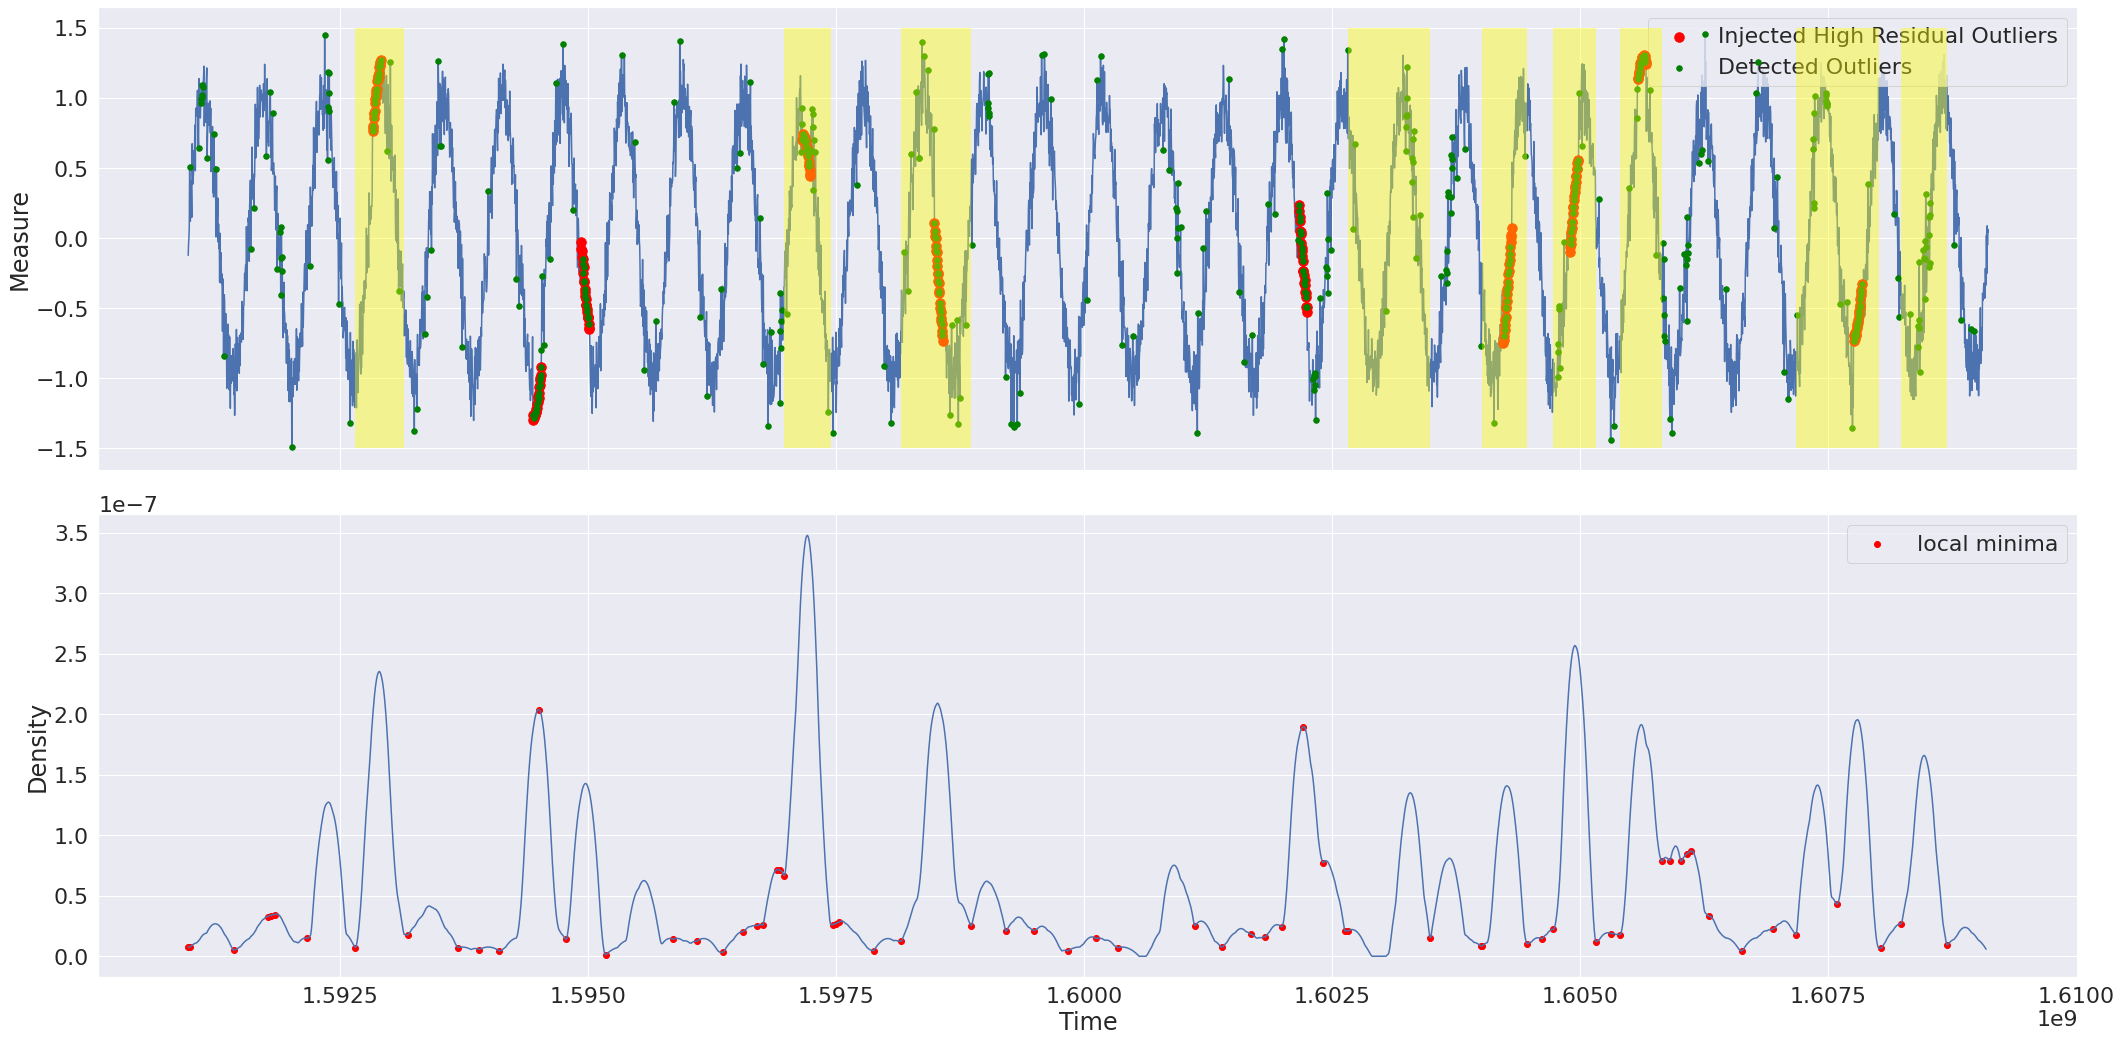

In [188]:
get_raw_and_density_plot(df, density_df, clusters_df, clusters_to_highlight, save_path='../figures/streaming/full_raw_and_density.svg')

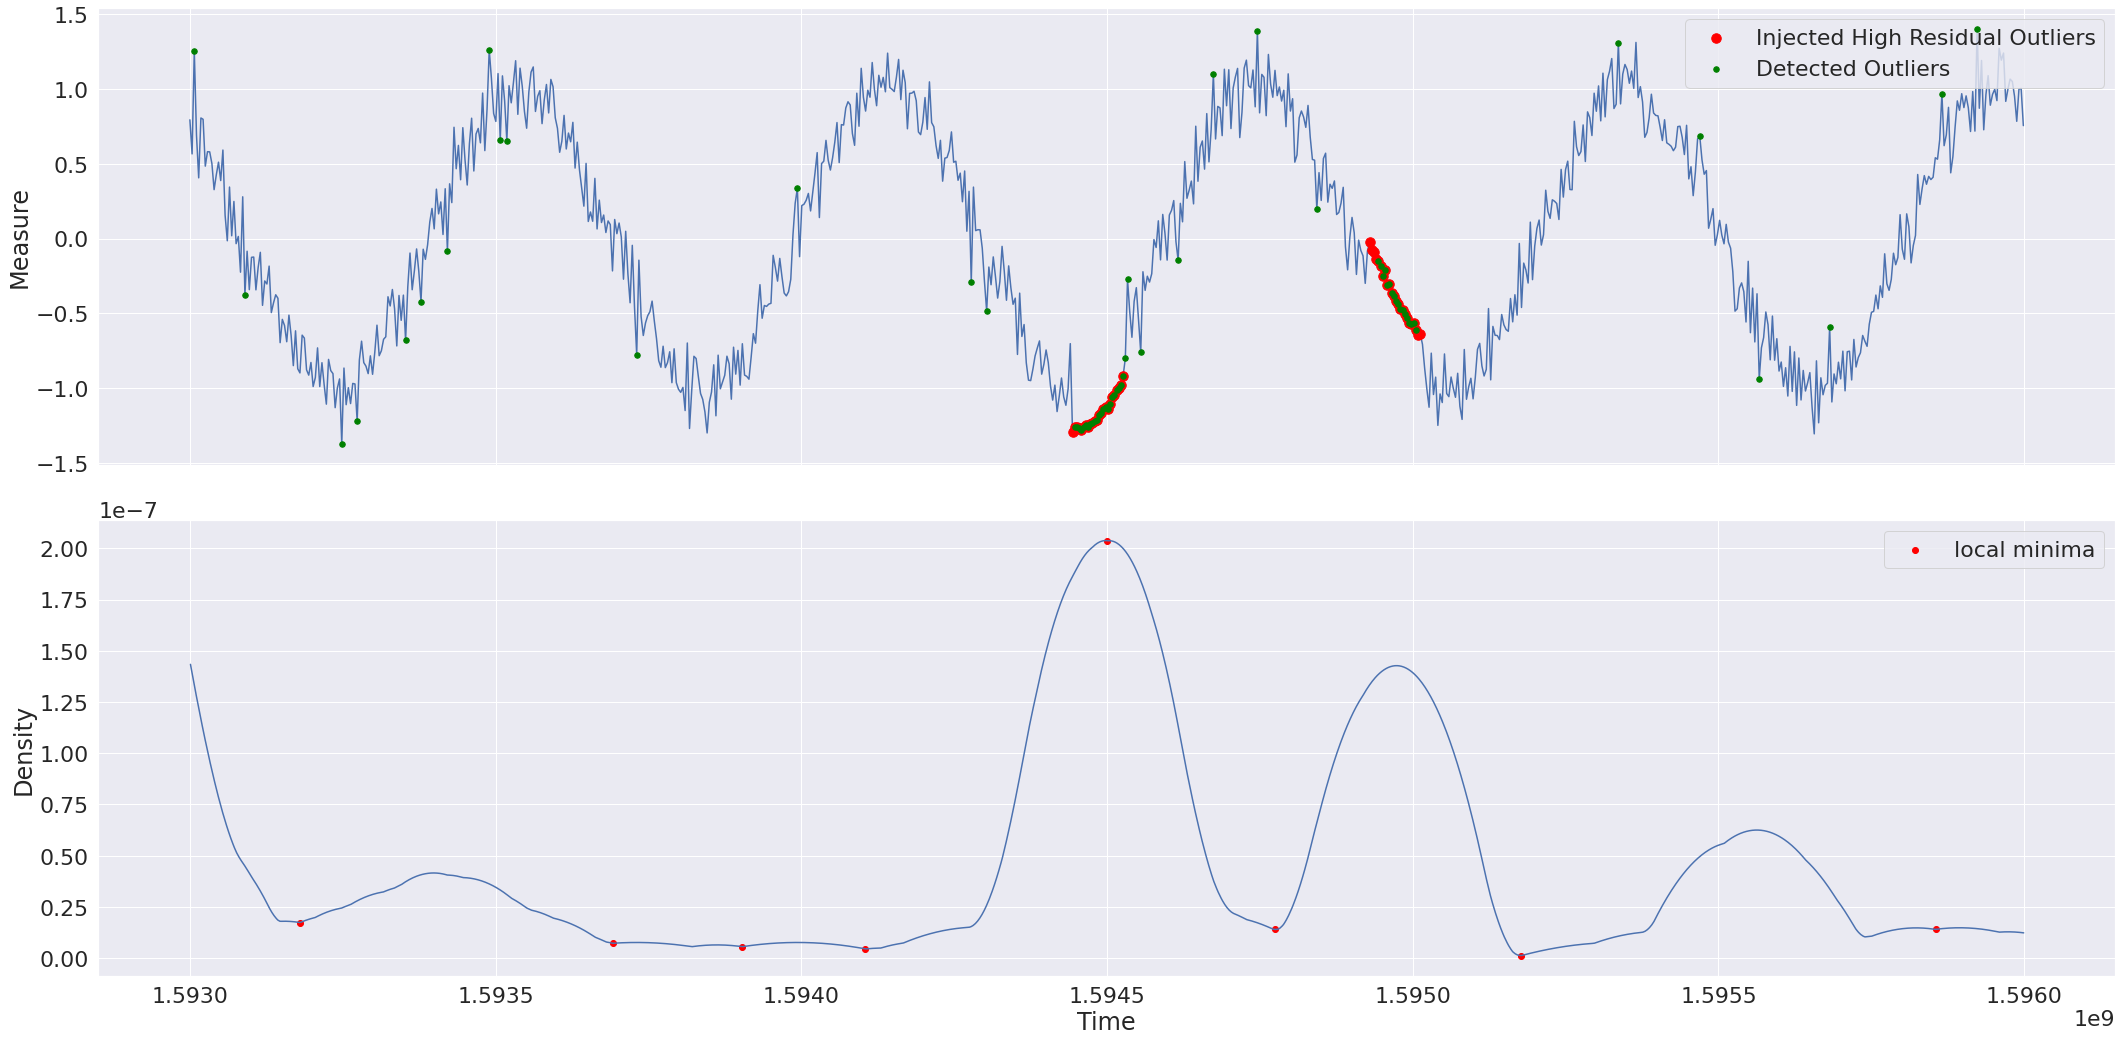

In [189]:
start=1.593e9
end=1.596e9
df_tmp = df[(df['unix_time'] >= start) & (df['unix_time'] <= end)]
density_df_tmp = density_df[(density_df['unix_time'] >= start) & (density_df['unix_time'] <= end)]
clusters_df_tmp = clusters_df[(clusters_df['start'] >= start) & (clusters_df['start'] <= end)]
clusters_to_highlight_tmp = clusters_to_highlight[(clusters_to_highlight['start'] >= start) & (clusters_to_highlight['start'] <= end)]
get_raw_and_density_plot(df_tmp, density_df_tmp, clusters_df_tmp, clusters_to_highlight_tmp, save_path='../figures/streaming/raw_and_density_1593_1596.svg')

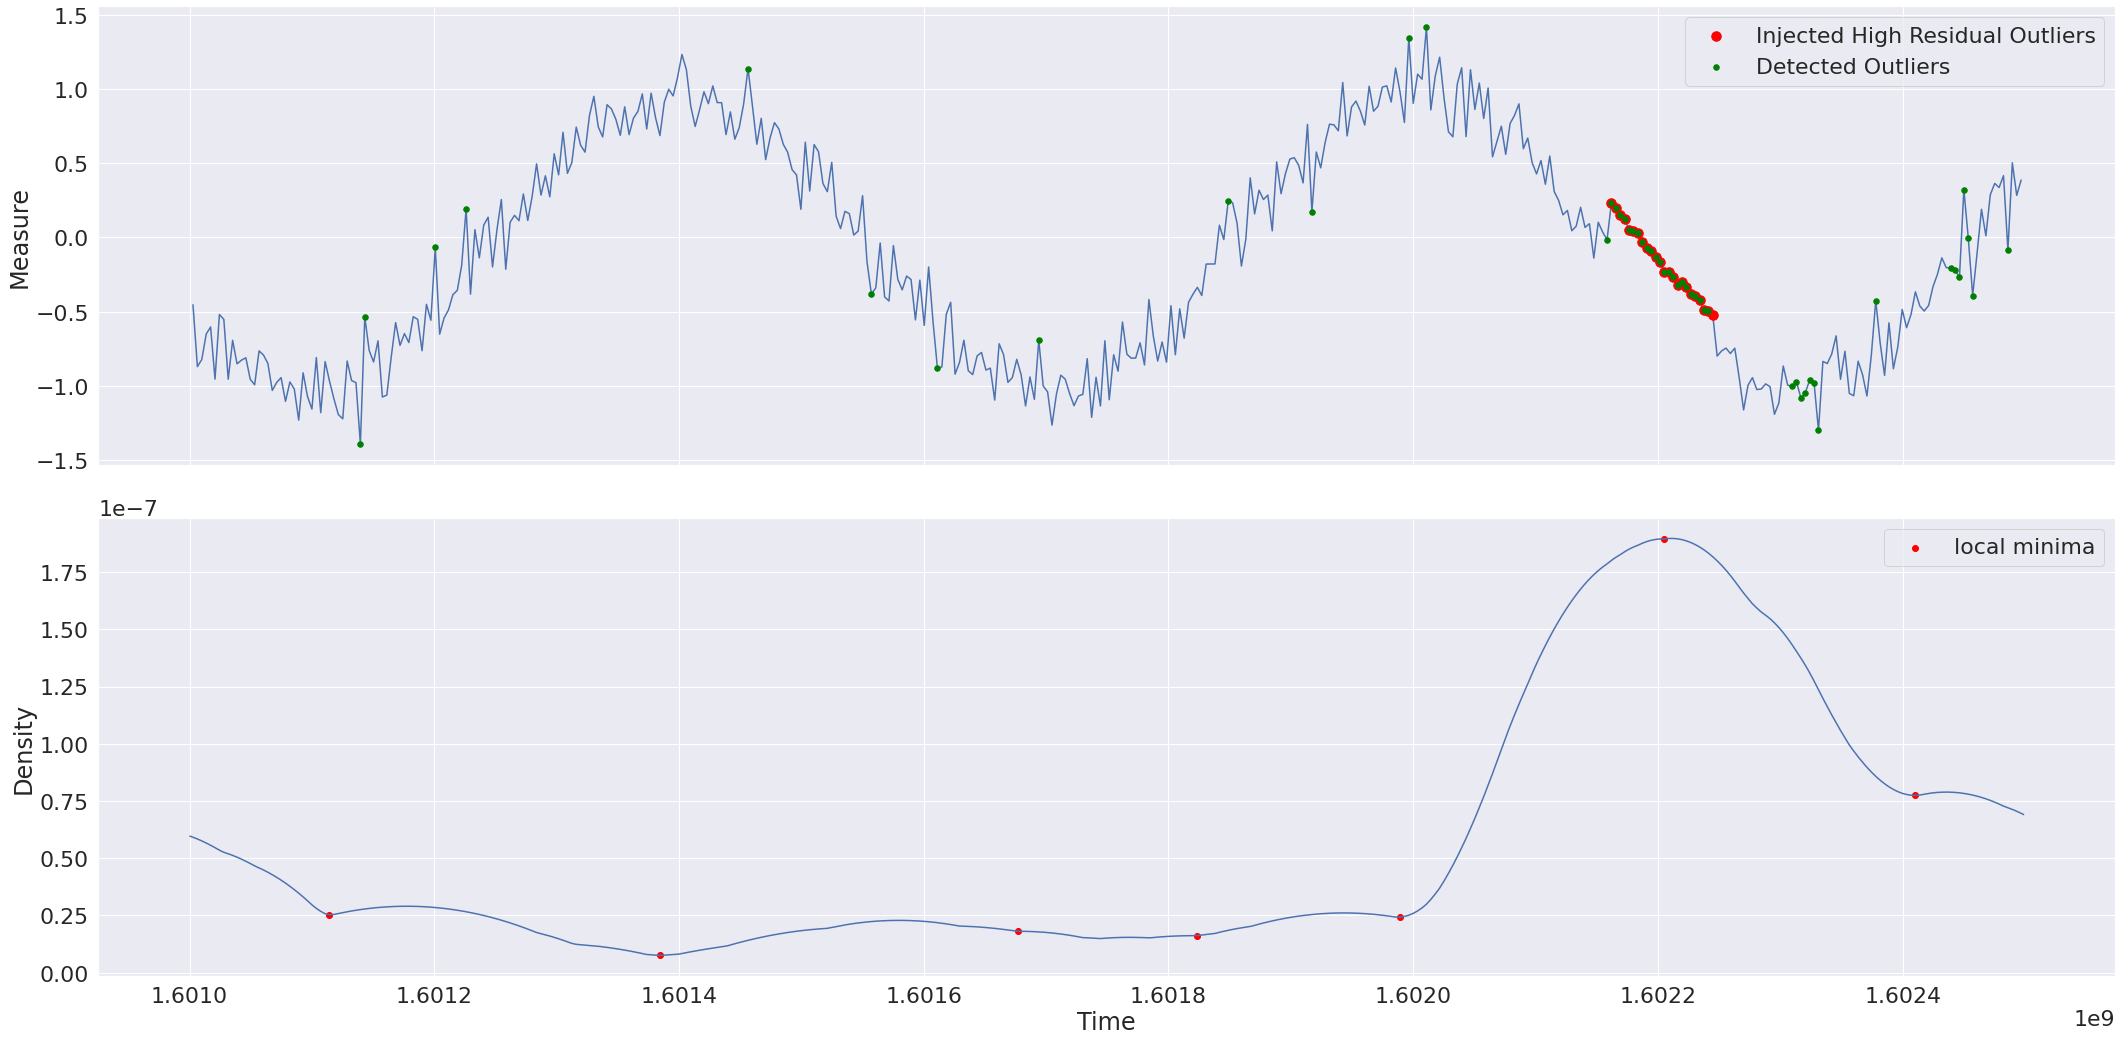

In [191]:
start=1.601e9
end=1.6025e9
df_tmp = df[(df['unix_time'] >= start) & (df['unix_time'] <= end)]
density_df_tmp = density_df[(density_df['unix_time'] >= start) & (density_df['unix_time'] <= end)]
clusters_df_tmp = clusters_df[(clusters_df['start'] >= start) & (clusters_df['start'] <= end)]
clusters_to_highlight_tmp = clusters_to_highlight[(clusters_to_highlight['start'] >= start) & (clusters_to_highlight['start'] <= end)]
get_raw_and_density_plot(df_tmp, density_df_tmp, clusters_df_tmp, clusters_to_highlight_tmp, save_path='../figures/streaming/raw_and_density_1601_16025.svg')

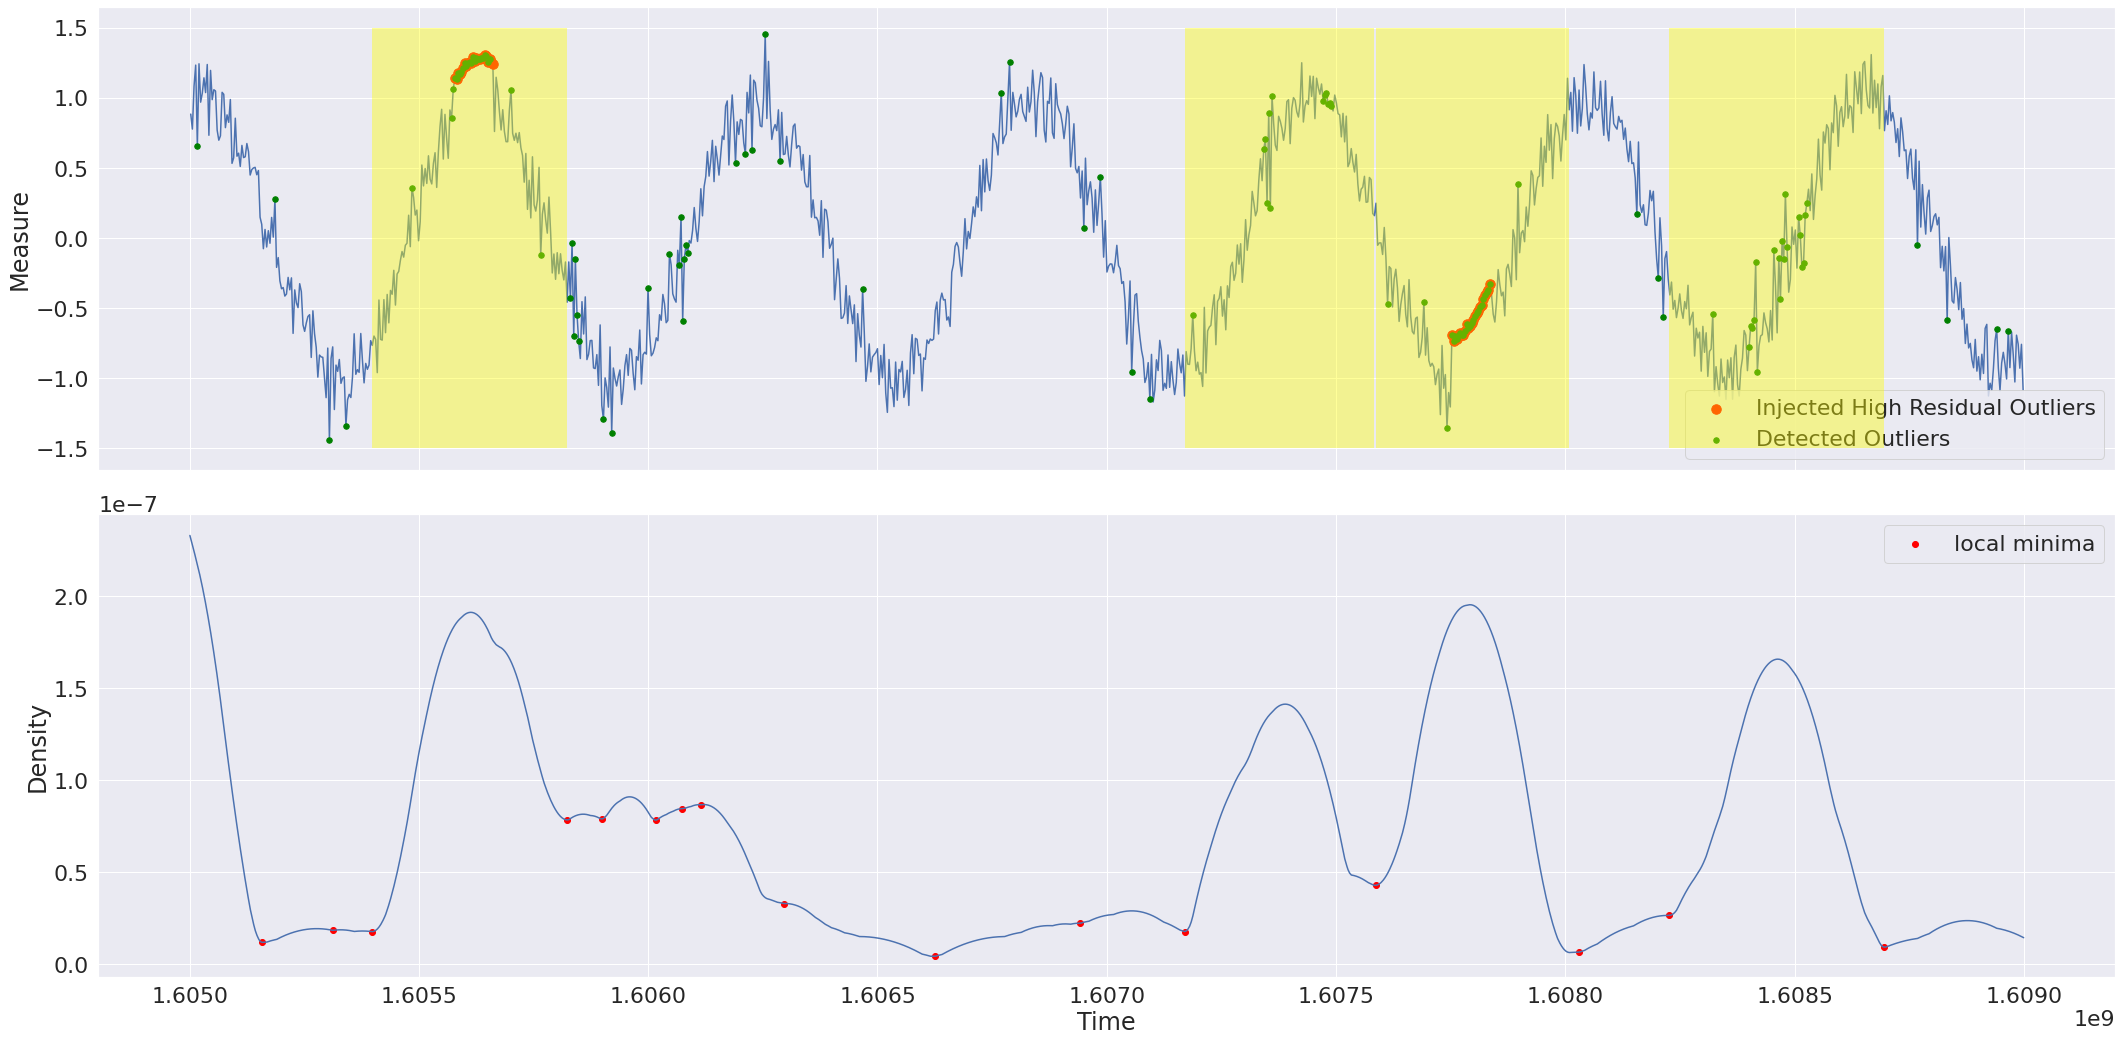

In [192]:
start=1.605e9
end=1.609e9
df_tmp = df[(df['unix_time'] >= start) & (df['unix_time'] <= end)]
density_df_tmp = density_df[(density_df['unix_time'] >= start) & (density_df['unix_time'] <= end)]
clusters_df_tmp = clusters_df[(clusters_df['start'] >= start) & (clusters_df['start'] <= end)]
clusters_to_highlight_tmp = clusters_to_highlight[(clusters_to_highlight['start'] >= start) & (clusters_to_highlight['start'] <= end)]
get_raw_and_density_plot(df_tmp, density_df_tmp, clusters_df_tmp, clusters_to_highlight_tmp, save_path='../figures/streaming/raw_and_density_1605_1609.svg')

# Real Datasets

In [16]:
def create_region_dataframes(raw_data_path, region_dataframes_dir, regions_dict):
    for file in regions_dict:
        if len(regions_dict[file]) > 0:
            # There is at least one anomalous region
            data_df = pd.read_csv(raw_data_path + file)
            data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])


            region_df_dict = {'start_timestamp': [], 'end_timestamp': [], 'region_id': [], 'start': [], 'end': [], 'length': []}
            region_id = 0
            for region in regions_dict[file]:
                row_start = data_df[data_df['timestamp'] == region[0]]
                row_end = data_df[data_df['timestamp'] == region[1]]
                region_df_dict['start_timestamp'].append(row_start.astype(str)['timestamp'].values[0])
                region_df_dict['end_timestamp'].append(row_end.astype(str)['timestamp'].values[0])
                region_df_dict['region_id'].append(region_id)
                region_df_dict['start'].append(row_start.index.values[0])
                region_df_dict['end'].append(row_end.index.values[0])
                region_df_dict['length'].append(row_end.index.values[0] - row_start.index.values[0] + 1)
                region_id += 1
            
            region_df = pd.DataFrame.from_dict(region_df_dict)
            
            # Save the region_df
            filename = os.path.basename(file)
            filename = os.path.splitext(filename)[0]

            region_df.to_pickle(region_dataframes_dir + filename + '_df.pickle')

In [17]:
with open('../data/labels/combined_windows.json') as f:
  windows_dict = json.load(f)

create_region_dataframes(raw_data_path='../data/raw/', region_dataframes_dir='../data/region_dataframes/', regions_dict=windows_dict)

In [10]:
file_path = '../data/raw/realKnownCause/nyc_taxi.csv'
filename = os.path.basename(file_path)
filename = os.path.splitext(filename)[0]

df = pd.read_csv(file_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.rename(columns={"value": "measure"})
df.to_pickle("../data/time_series_dataframes/" + filename + '_df.pickle')


df

,timestamp,measure
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


# NYC Taxi

In [14]:
regions_df = pd.read_pickle('../data/region_dataframes/nyc_taxi_df.pickle')
df = pd.read_pickle('../real_data/NAB/nyc_taxi/df.pickle')
df = df.sort_values(by='unix_time')

# Add unix time to the regions_df
regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values
regions_df

,start_timestamp,end_timestamp,region_id,start,end,length,unix_start,unix_end
0,2014-10-30 15:30:00,2014-11-03 22:30:00,0,5839,6045,207,1.414683e+09,1.415054e+09
1,2014-11-25 12:00:00,2014-11-29 19:00:00,1,7080,7286,207,1.416917e+09,1.417288e+09
2,2014-12-23 11:30:00,2014-12-27 18:30:00,2,8423,8629,207,1.419334e+09,1.419705e+09
3,2014-12-29 21:30:00,2015-01-03 04:30:00,3,8731,8937,207,1.419889e+09,1.420259e+09
4,2015-01-24 20:30:00,2015-01-29 03:30:00,4,9977,10183,207,1.422131e+09,1.422502e+09


In [17]:
clusters_df = pd.read_pickle('../real_data/NAB/nyc_taxi/clusters_df.pickle').sort_values(by='area', ascending=False)
density_df = pd.read_pickle('../real_data/NAB/nyc_taxi/density_df.pickle')

density_df

# # Add the `density_at_start` column to the clusters_df
# densities = []
# for index, row in clusters_df.iterrows():
#     density = density_df[density_df['unix_time']==row['start']]['density'].values[0]
#     densities.append(density)
# clusters_df['density_at_start'] = densities

# clusters_df

,sample,log_density,density,timestamp
0,1.404173e+09,-18.990500,5.656275e-09,2014-07-01 00:00:00.000000000
1,1.404173e+09,-18.984761,5.688832e-09,2014-07-01 00:09:59.961239100
2,1.404174e+09,-18.979064,5.721336e-09,2014-07-01 00:19:59.922478199
3,1.404175e+09,-18.973408,5.753782e-09,2014-07-01 00:29:59.883717060
4,1.404175e+09,-18.967795,5.786169e-09,2014-07-01 00:39:59.844956160
...,...,...,...,...
30955,1.422745e+09,-16.896258,4.592490e-08,2015-01-31 22:50:00.155043840
30956,1.422745e+09,-16.901215,4.569784e-08,2015-01-31 23:00:00.116282940
30957,1.422746e+09,-16.906219,4.546972e-08,2015-01-31 23:10:00.077521801
30958,1.422746e+09,-16.911272,4.524056e-08,2015-01-31 23:20:00.038760900


In [ ]:
regions_df = pd.read_pickle('../streaming_data/high_residual/consistent/regions_df.pickle')
df = pd.read_pickle('../streaming_data/high_residual/consistent/df_full.pickle')
df = df.sort_values(by='unix_time')

# Add unix time to the regions_df
regions_df['unix_start'] = df.loc[regions_df['start']]['unix_time'].values
regions_df['unix_end'] = df.loc[regions_df['end']]['unix_time'].values
regions_df

In [14]:
df_tmp = pd.read_pickle('../real_data/data_df.pickle')
df_tmp.columns

Index(['MOTS_ID', 'DEVICE', 'DVC_CATEGORY_TITLE', 'DVC_SUB_CATEGORY_TITLE',
       'OS', 'TECH_TYPE', 'PLANGRP', 'PLANFRIENDLY', 'PLAN4', 'PLAN',
       'BKTSZMB', 'SALES_CLUSTER', 'METRIC_NAME', 'timestamp', 'measure',
       'expected', 'dev', 'lookback', 'count', 'num_alerts', 'grp_size'],
      dtype='object')

In [11]:
df[df['timestamp'] == '2013-12-10 06:25:00'].index.values[0]

2126

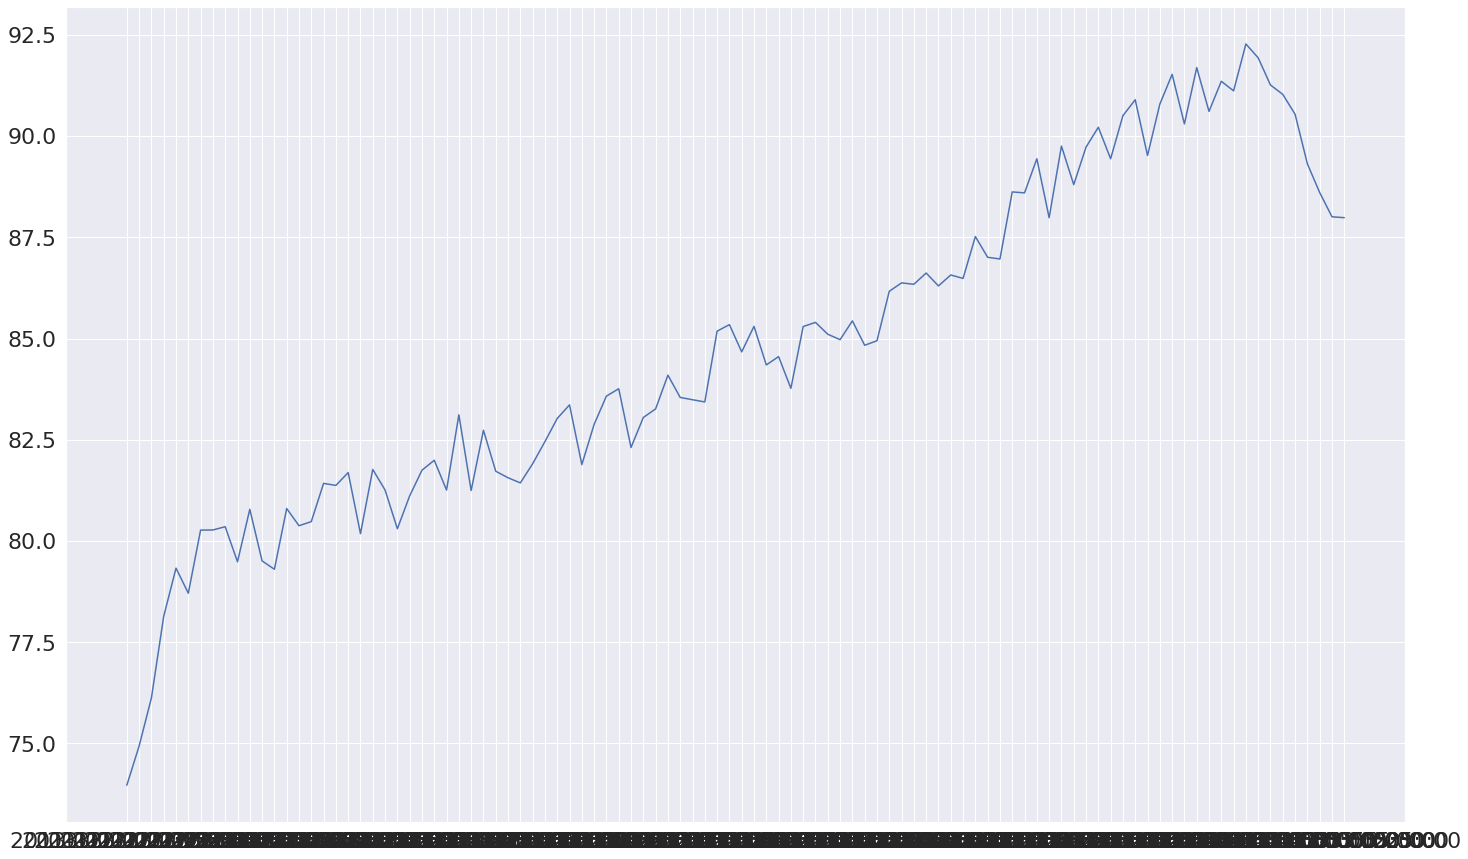

In [4]:
plt.plot(df['timestamp'][0:100], df['value'][0:100])

In [7]:
regions_df = pd.read_pickle('../real_data/regions_df.pickle')
regions_df

,start_timestamp,end_timestamp,region_id,start,end,length
0,2020-03-10,2020-03-17,0,159,166,8
1,2020-05-25,2020-06-3,1,235,244,10
2,2020-09-25,2020-10-8,2,358,371,14


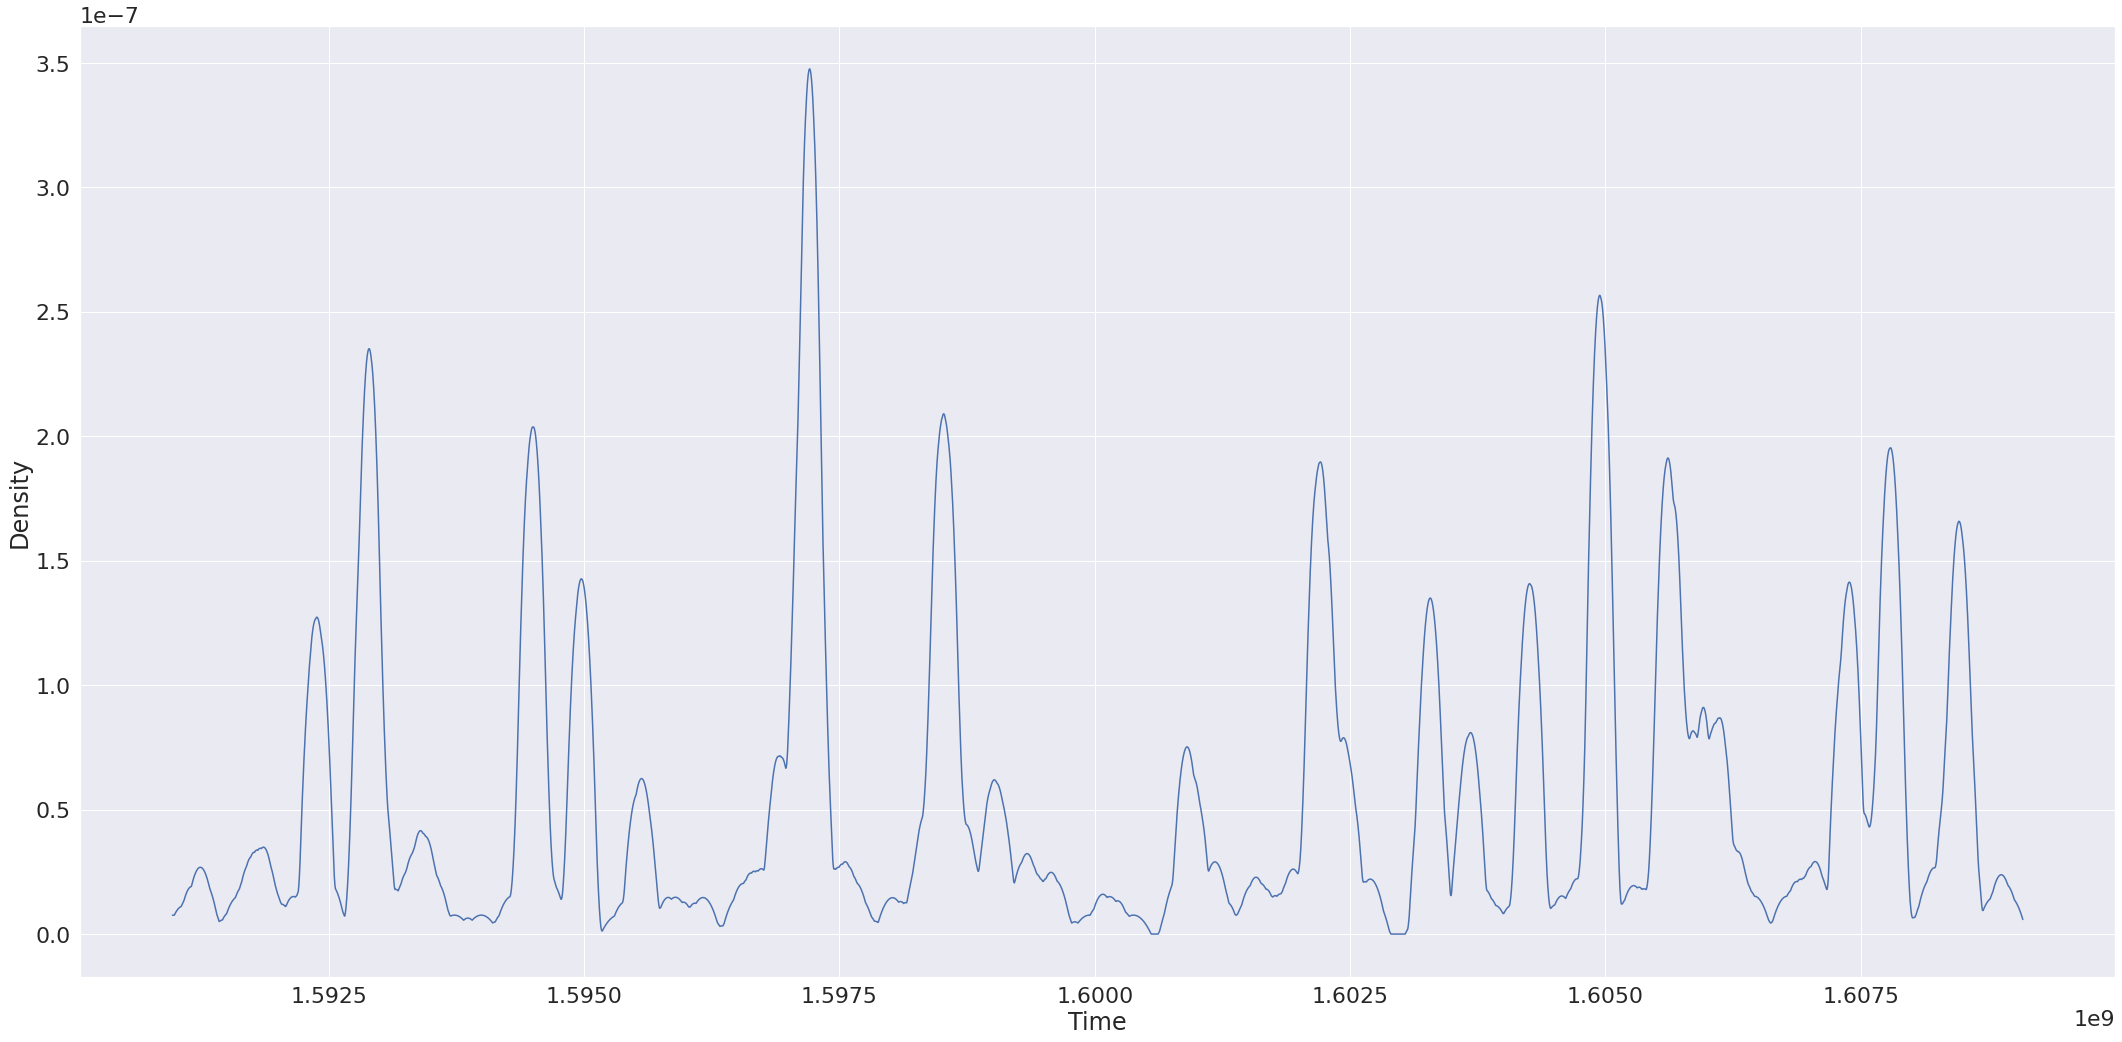

In [10]:
density_df = pd.read_pickle('../streaming_data/high_residual/consistent/outputs/size_5034/density_df.pickle')

plt.plot(density_df['unix_time'], density_df['density']);plt.xlabel('Time');plt.ylabel('Density');plt.tight_layout()

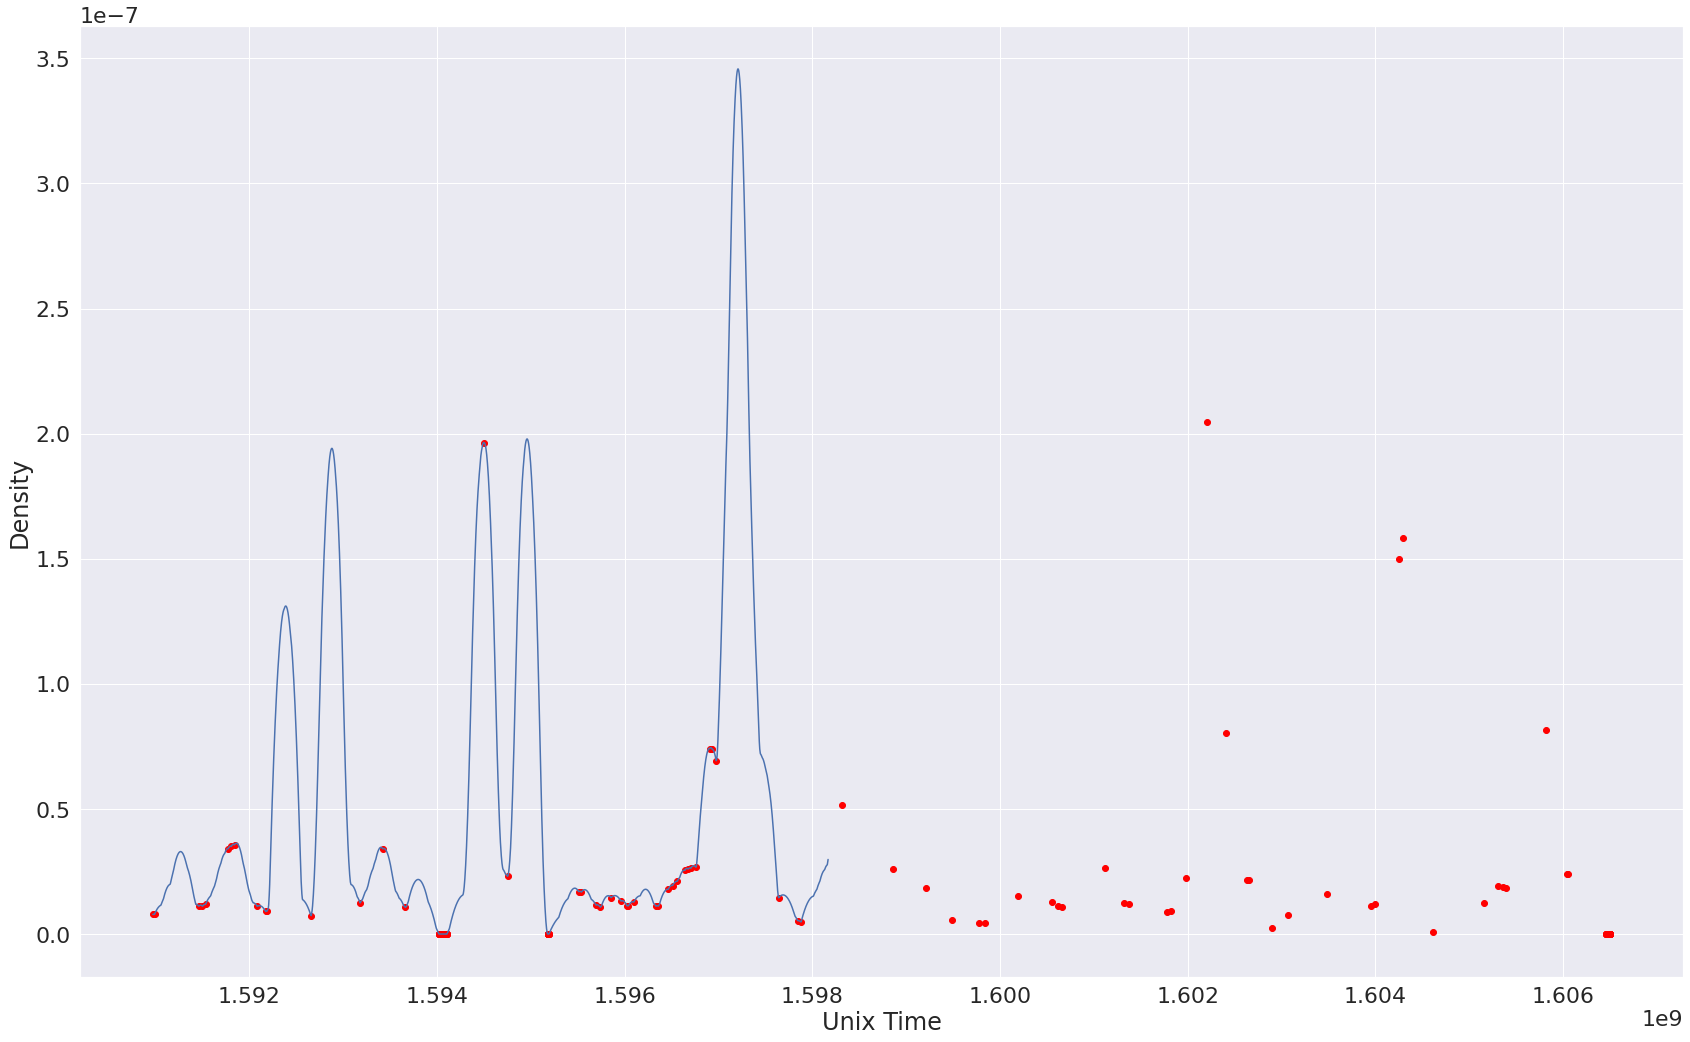

In [67]:
plt.plot(unix_time_arr[:6000], density_arr[:6000])
plt.scatter(minima_unix[:200], minima_density[:200], color='red')

plt.xlabel('Unix Time');plt.ylabel('Density');plt.tight_layout()

Text(0.5, 0, 'Time')

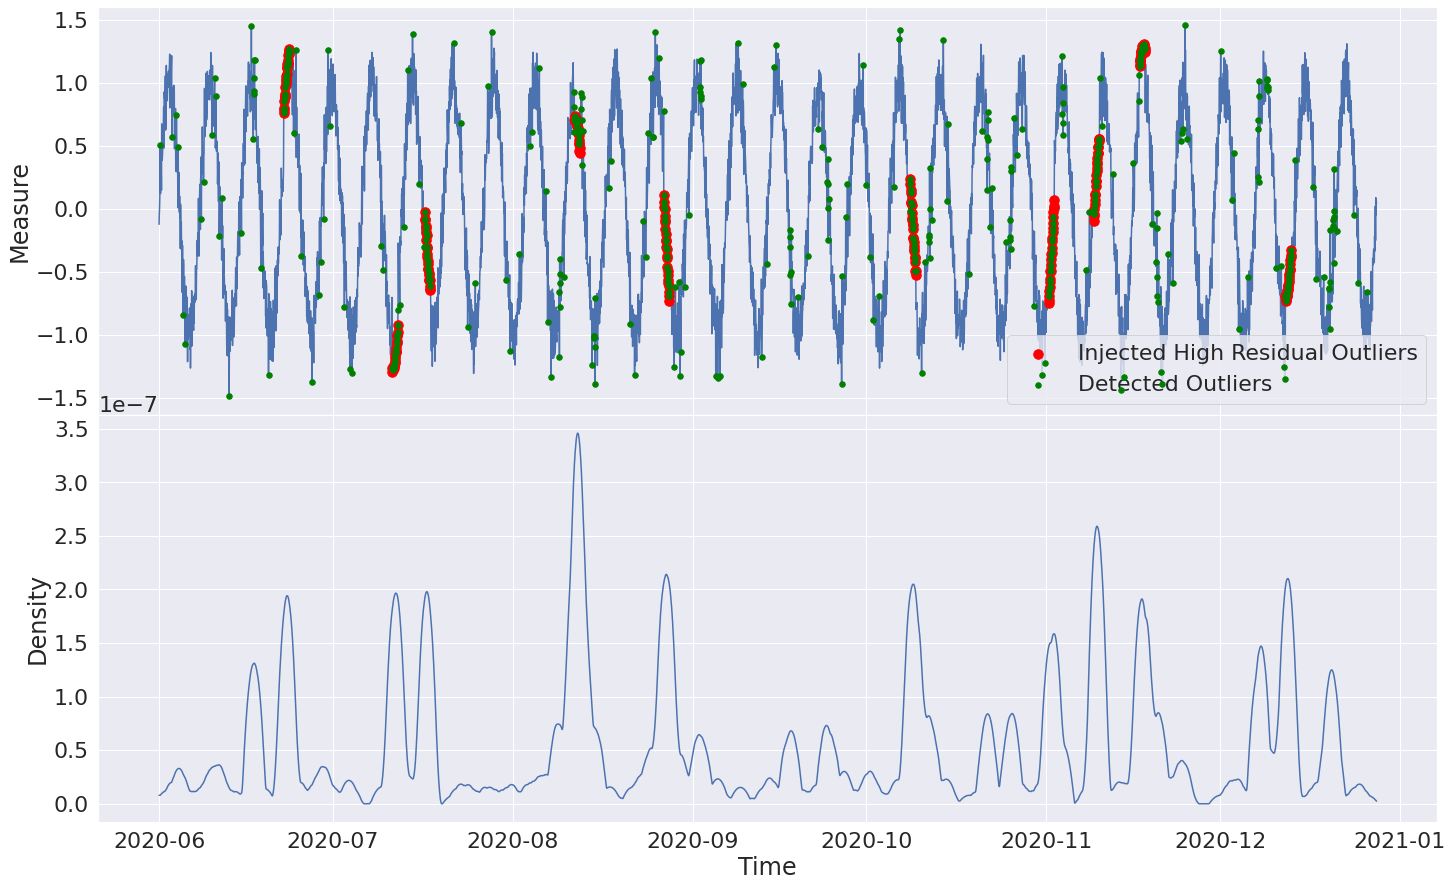

In [68]:
df = cur_df.sort_values(by='timestamp')

# Plot the Figure
fig, axs = plt.subplots(2, sharex=True)
fig.subplots_adjust(hspace=0)

axs[0].plot(df['timestamp'], df['measure'])
axs[0].scatter(df[df['outlier_type']=='high_residual']['timestamp'].values, df[df['outlier_type']=='high_residual']['measure'].values, s=90, c='red', zorder=10, label='Injected High Residual Outliers')
axs[0].scatter(df[df['raw_voting_score']>0]['timestamp'].values, df[df['raw_voting_score']>0]['measure'].values, s=30, c='green', zorder=10, label='Detected Outliers')
axs[0].set_ylabel('Measure');axs[0].legend()

axs[1].plot(density_df['timestamp'], density_df['density'])
axs[1].set_ylabel('Density');axs[1].set_xlabel('Time')

In [73]:
def get_clusters_df(samples, density_dist, minima_idx_list, points):
    '''
    samples (list of float): The time positions where the density is computed

    density_dist (list of float): The probability density of the alerts at each specified sampled time

    minima_idx_list (list of int): The indices in the `samples` array where the local minima occur

    points (list of float): A list with the timestamps of the detected alerts (i.e. the raw data points for which we estimated the density distribution)
    '''

    assert len(minima_idx_list) >= 2, 'The minima array should have at least 2 points'

    data = {'cluster_id': [], 'start': [], 'end': [], 'point_start': [], 'point_end': [], 'time_length': [], 'num_points': []}

    # First Cluster (Everything before the first local minimum is a cluster)
    first_cluster_pts = points[points < samples[minima_idx_list[0]]]
    if len(first_cluster_pts):
        data['cluster_id'].append(0)
        data['start'].append(samples[0])
        data['end'].append(samples[minima_idx_list[0]])
        data['point_start'].append(min(first_cluster_pts))
        data['point_end'].append(max(first_cluster_pts))
        data['time_length'].append(data['end'][0] - data['start'][0])
        data['num_points'].append(len(first_cluster_pts))


    # Compute all clusters between two consecutive local minima
    for i in range(0, len(minima_idx_list)-1):
        # Ensure that there is at least one observed outlier in each cluster
        cluster_pts = points[(points > samples[minima_idx_list[i]]) * (points <= samples[minima_idx_list[i+1]])]
        if len(cluster_pts) > 0:
            data['cluster_id'].append(i+1)
            start = samples[minima_idx_list[i]]
            end = samples[minima_idx_list[i+1]]
            data['start'].append(start)
            data['end'].append(end)
            data['point_start'].append(min(cluster_pts))
            data['point_end'].append(max(cluster_pts))
            data['time_length'].append(end-start)
            data['num_points'].append(len(cluster_pts))


    # Last Cluster (Everything after the last local minumum)
    last_cluster_pts = points[points >= samples[minima_idx_list[-1]]]
    if len(last_cluster_pts) > 0:
        data['cluster_id'].append(len(minima_idx_list))
        start = samples[minima_idx_list[-1]]
        end = samples[-1]
        data['start'].append(start)
        data['end'].append(end)
        data['point_start'].append(min(last_cluster_pts))
        data['point_end'].append(max(last_cluster_pts))
        data['time_length'].append(end-start)
        data['num_points'].append(len(last_cluster_pts))

    clusters_df = pd.DataFrame.from_dict(data)

    return clusters_df

In [74]:
clusters_df = get_clusters_df(
    samples=density_df["unix_time"].to_numpy(), density_dist=density_df["density"].to_numpy(), minima_idx_list=mi,
    points=cur_df[cur_df['raw_voting_score'] > 0]['unix_time'].to_numpy().reshape(-1,1)
)
clusters_df

,cluster_id,start,end,point_start,point_end,time_length,num_points
0,1,1.590970e+09,1.590988e+09,1.590984e+09,1.590984e+09,17997.618890,1
1,2,1.590988e+09,1.591459e+09,1.591160e+09,1.591358e+09,471537.614922,5
2,5,1.591531e+09,1.591772e+09,1.591600e+09,1.591758e+09,241168.093128,3
3,6,1.591772e+09,1.591805e+09,1.591798e+09,1.591798e+09,32395.714002,1
4,7,1.591805e+09,1.591841e+09,1.591819e+09,1.591819e+09,35995.237780,1
...,...,...,...,...,...,...,...
60,292,1.607170e+09,1.607580e+09,1.607188e+09,1.607490e+09,410345.710695,13
61,293,1.607580e+09,1.607785e+09,1.607612e+09,1.607785e+09,205172.855348,14
62,294,1.607785e+09,1.608009e+09,1.607789e+09,1.607897e+09,223170.474238,15
63,296,1.608041e+09,1.608660e+09,1.608156e+09,1.608520e+09,619118.089821,17


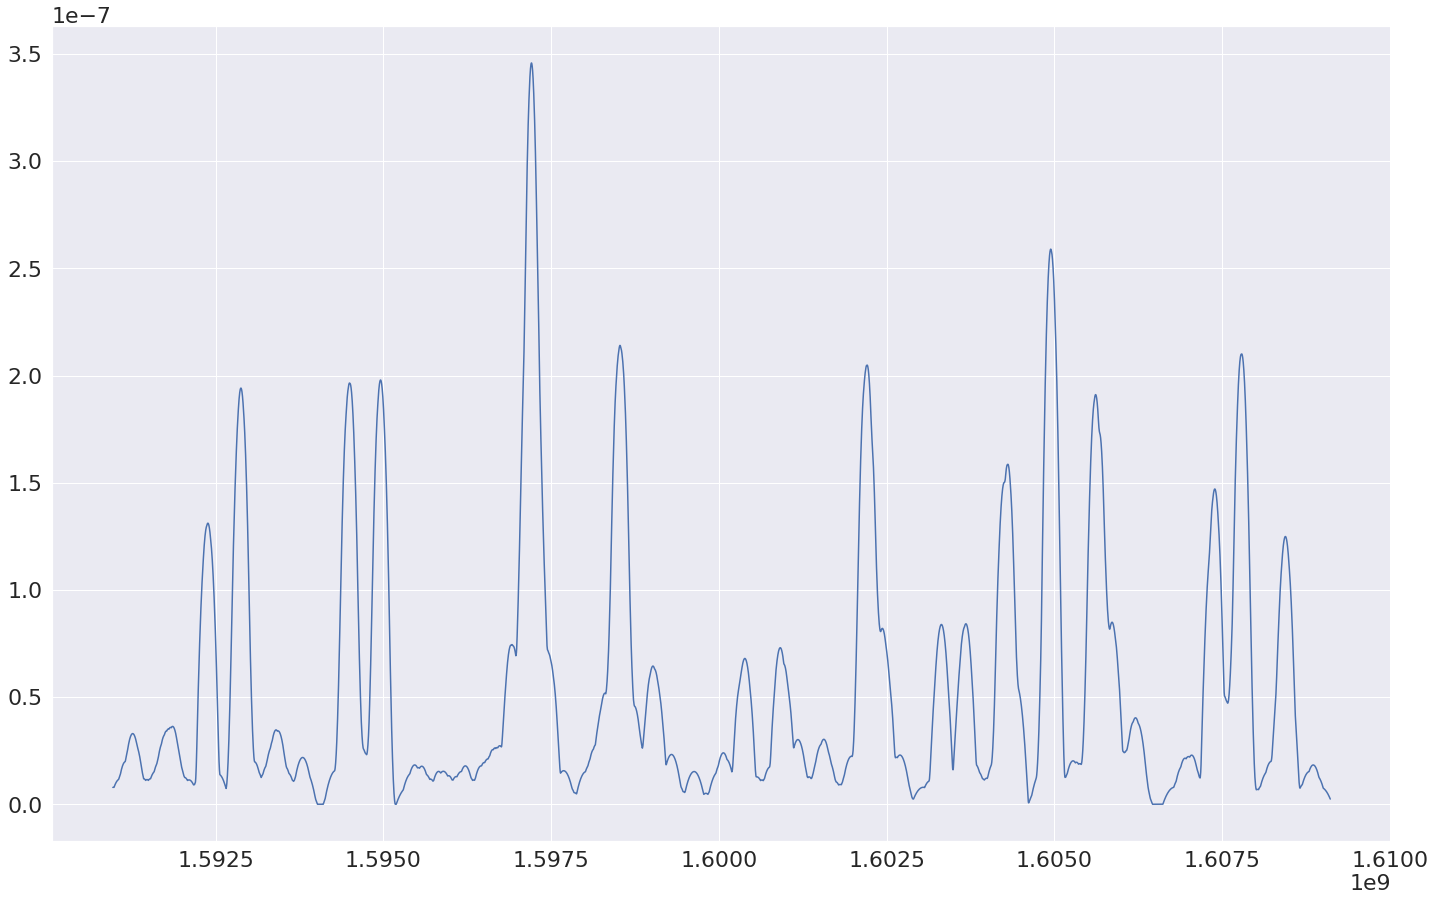

In [75]:
plt.plot(density_df['unix_time'], density_df['density'])
plt.scatter(clusters_df)